## Importing libraries and Dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Datasets/winequality.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


# Exploratory Data Analysis

In [5]:
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [6]:
#fill missing values by means
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())
 
df.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

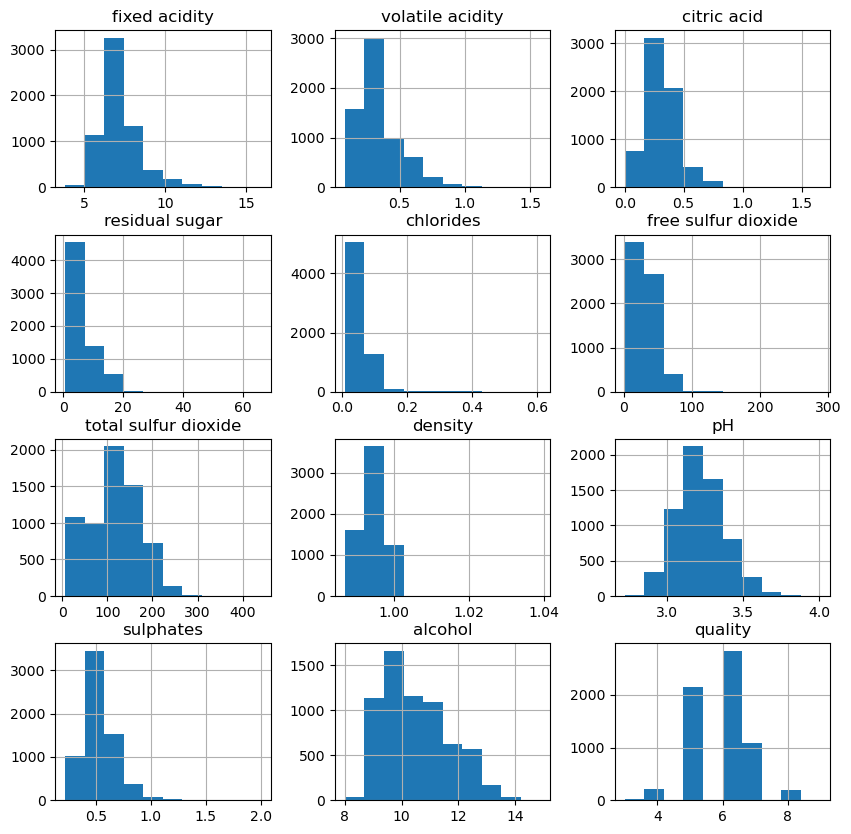

In [7]:
df.hist(bins=10, figsize=(10, 10))
plt.show()

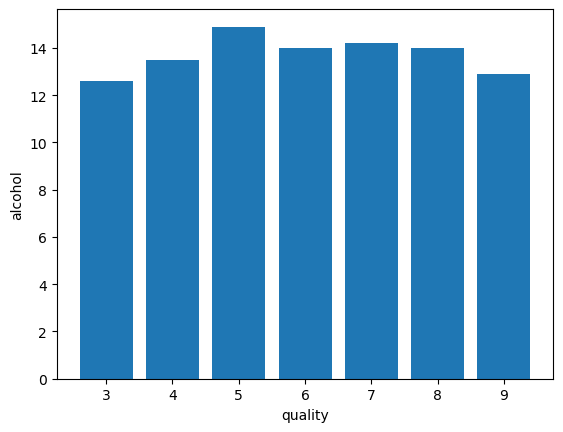

In [8]:
plt.bar(df['quality'], df['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()

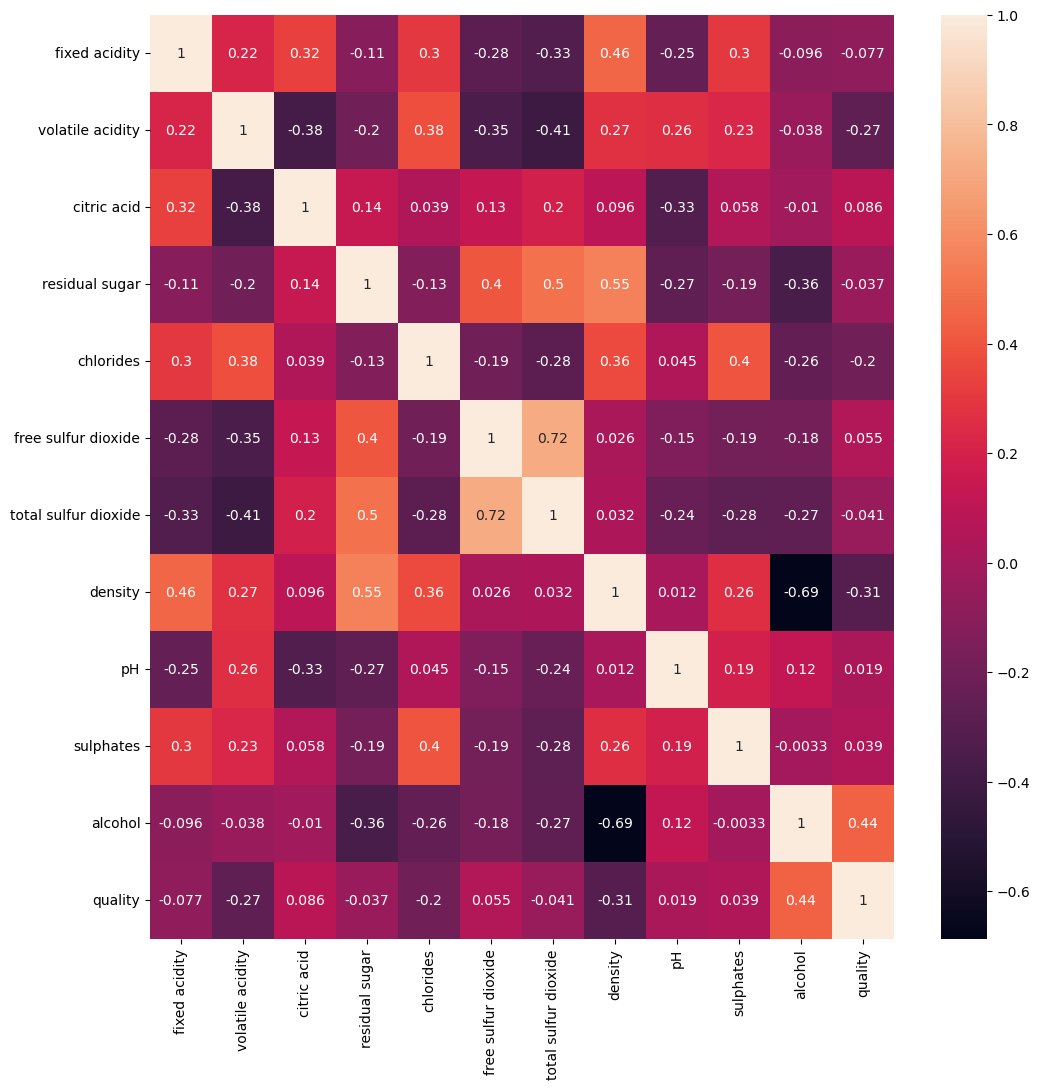

In [9]:
#heatmap for all correlations
plt.figure(figsize=(12, 12))
sb.heatmap(df.corr(), annot=True)
plt.show()

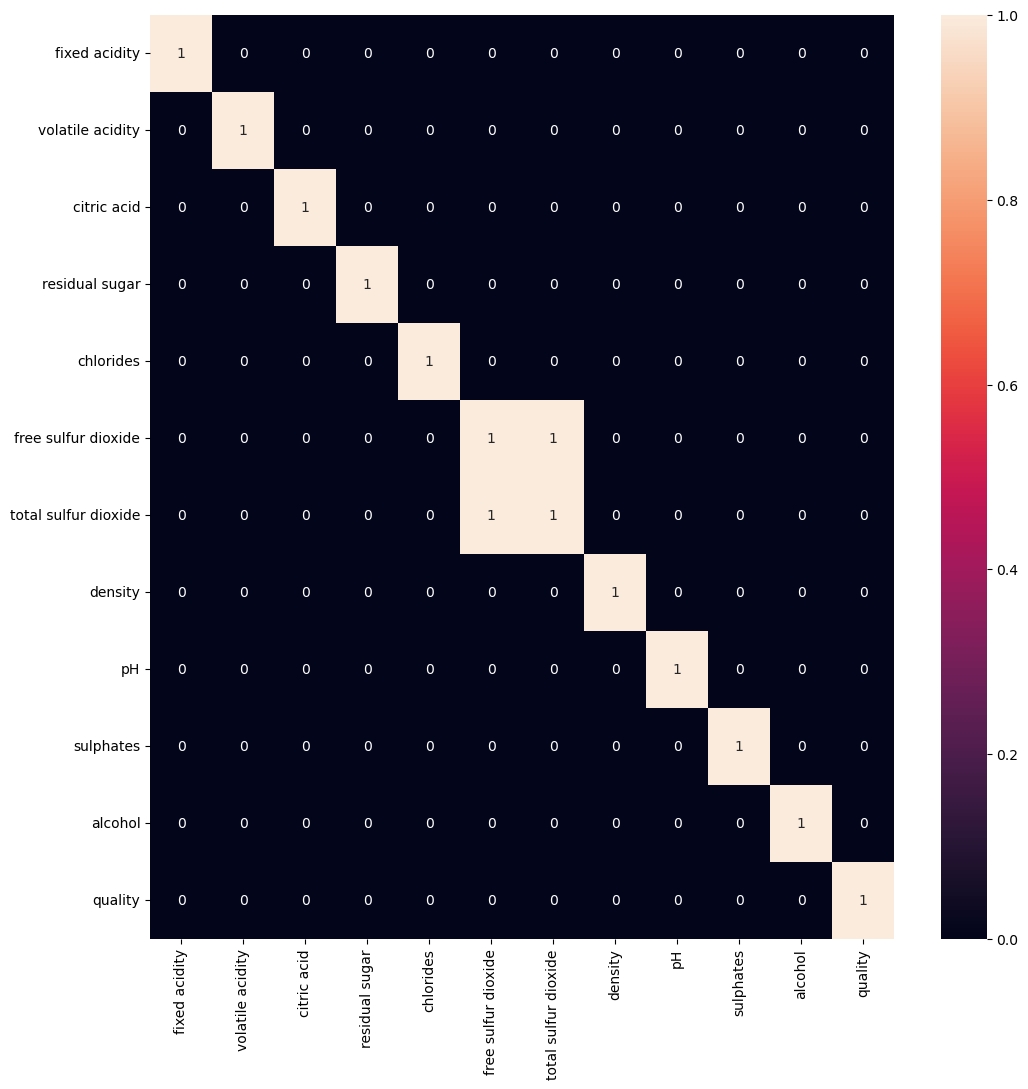

In [10]:
#heatmap for correlations greater than 0.7
plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True)
plt.show()

From the above heat map we can conclude that the ‘total sulphur dioxide’ and ‘free sulphur dioxide‘ are highly correlated features so, we will remove them.

In [11]:
df.drop('total sulfur dioxide', axis=1, inplace=True)

## Model Development

In [13]:
df['best quality'] = [1 if x > 5 else 0 for x in df.quality]
df.replace({'white': 1, 'red': 0}, inplace=True)

In [40]:
features = df.drop(['quality', 'best quality'], axis=1)
target = df['best quality']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

x_train.shape, x_test.shape

((5197, 11), (1300, 11))

In [41]:
#Normalising the data before training

norm = MinMaxScaler()
x_train = norm.fit_transform(x_train)
x_test = norm.transform(x_test)

In [18]:
best_model = None
best_score = 0

models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf'), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier()]
 
for i in range(3):
    models[i].fit(x_train, y_train)

    train_score = metrics.roc_auc_score(y_train, models[i].predict(x_train))
    val_score = metrics.roc_auc_score(y_test, models[i].predict(x_test))
    
    print(f'{models[i]} : ')
    print('Training Accuracy : ', train_score)
    print('Validation Accuracy : ', val_score)
    
    if val_score > best_score:
        best_model = models[i]
        best_score = val_score

print('Best Model: ', best_model)
print('Best Validation Accuracy: ', best_score)

LogisticRegression() : 
Training Accuracy :  0.6976795962952589
Validation Accuracy :  0.7228569126854456
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accuracy :  0.981007109792801
Validation Accuracy :  0.7996671861114398
SVC() : 
Training Accuracy :  0.6989455704654206
Validatio

In [34]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter space
param_dist = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(3, 16),
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 0.9],
    'min_child_weight': [ 1, 3, 5, 7 ],
    'colsample_bytree': [0.3, 0.4, 0.5 , 0.7],
    'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]
}

# Define objective function
scoring = 'roc_auc'

# Define XGBoost model

# Run Random Search algorithm
random_search = RandomizedSearchCV(
    models[1], param_distributions=param_dist, n_iter=10, cv=5, scoring=scoring, verbose=2, n_jobs=-1
)
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                     

In [35]:
# Get best hyperparameters and model
best_model = random_search.best_estimator_
best_params = random_search.best_params_

In [37]:
best_params

{'subsample': 0.5,
 'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.3,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [42]:
xgb = XGBClassifier(**best_params)

In [43]:
xgb.fit(x_train, y_train)
print('Training Accuracy : ', metrics.roc_auc_score(y_train, xgb.predict(x_train)))
print('Validation Accuracy : ', metrics.roc_auc_score(y_test, xgb.predict(x_test)))

Training Accuracy :  1.0
Validation Accuracy :  0.7870469438773069


# Model Evaluation

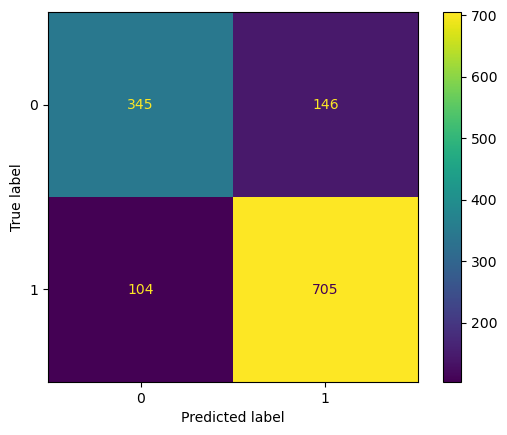

In [44]:
metrics.plot_confusion_matrix(xgb, x_test, y_test)
plt.show()

In [45]:
# classification report
print(metrics.classification_report(y_test,
                                    xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       491
           1       0.83      0.87      0.85       809

    accuracy                           0.81      1300
   macro avg       0.80      0.79      0.79      1300
weighted avg       0.81      0.81      0.81      1300

